# EDA on the IMDB dataset

## Downloading the datasets

In [4]:
!mkdir -p imdb; \
curl -o imdb/title.basics.tsv.gz https://datasets.imdbws.com/title.basics.tsv.gz; \
curl -o imdb/title.akas.tsv.gz https://datasets.imdbws.com/title.akas.tsv.gz; \
curl -o imdb/title.crew.tsv.gz https://datasets.imdbws.com/title.crew.tsv.gz; \
curl -o imdb/title.episode.tsv.gz https://datasets.imdbws.com/title.episode.tsv.gz; \
curl -o imdb/title.principals.tsv.gz https://datasets.imdbws.com/title.principals.tsv.gz; \
curl -o imdb/title.ratings.tsv.gz https://datasets.imdbws.com/title.ratings.tsv.gz; \
curl -o imdb/name.basics.tsv.gz https://datasets.imdbws.com/name.basics.tsv.gz; \
gunzip imdb/*.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  188M  100  188M    0     0  10.9M      0  0:00:17  0:00:17 --:--:-- 14.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  418M  100  418M    0     0  8207k      0  0:00:52  0:00:52 --:--:-- 4653k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70.1M  100 70.1M    0     0  8706k      0  0:00:08  0:00:08 --:--:-- 12.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.4M  100 45.4M    0     0  7279k      0  0:00:06  0:00:06 --:--:-- 10.6M
  % Total    % Received % Xferd  Average Speed   Tim

In [45]:
!mkdir -p movielens; \
curl -L -o movielens/movielens-dataset.zip https://www.kaggle.com/api/v1/datasets/download/grouplens/movielens-20m-dataset; \
unzip movielens/movielens-dataset.zip -d movielens

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  195M  100  195M    0     0  4943k      0  0:00:40  0:00:40 --:--:-- 3275k     0  0:00:37  0:00:31  0:00:06 4678k
Archive:  movielens/movielens-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


I also opted to download the more updated (2023) version of the MovieLens dataset from `https://grouplens.org/datasets/movielens/` 

In [10]:
!mkdir -p movielens32m; \
curl -L -o movielens32m/movielens-dataset.zip https://files.grouplens.org/datasets/movielens/ml-32m.zip ; \
unzip movielens32m/movielens-dataset.zip -d movielens32m

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  227M  100  227M    0     0   158k      0  0:24:30  0:24:30 --:--:--  324k 0  0:27:54  0:01:41  0:26:13  127k0  0:28:33  0:03:19  0:25:14  162kk      0  0:32:30  0:04:33  0:27:57 60196  119k      0  0:32:32  0:04:42  0:27:50  121k 0:27:29  0:08:04  0:19:25  264kk      0  0:26:50  0:15:30  0:11:20  220k0:26:02  0:19:54  0:06:08  313kk
Archive:  movielens32m/movielens-dataset.zip
   creating: movielens32m/ml-32m/
  inflating: movielens32m/ml-32m/tags.csv  
  inflating: movielens32m/ml-32m/links.csv  
  inflating: movielens32m/ml-32m/README.txt  
  inflating: movielens32m/ml-32m/checksums.txt  
  inflating: movielens32m/ml-32m/ratings.csv  
  inflating: movielens32m/ml-32m/movies.csv  


## Load the datasets into DuckDB, then do data quality profiling

Run `ingest_datasets.py` first. This will store the datasets into a DuckDB persistent store.

Next run `profile_datasets.py` to produce HTML files containing analysis on data quality and profiles of each table. I have provided the outputs I generated in the `profiling` folder. Note that I set a limit of 10M records for profiling, as some of the datasets have more than 10M rows, which my PC could not handle.

I added the [TMDB Movies 1M dataset](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies) from Kaggle. 

For the MovieLens datasets and TMDB dataset, you can also run `ingest_other_datasets.py` which also includes profiling.

## Data cleaning and exploration

We list below some notable findings from the data profiling.

title_basics
- more than 75% of the titles are TV episodes
- there are many startYear values greater than 2024! this means these are movies planned for the future
- a significant number (12.5%) have missing startYear - a value that is important
- most (68%) do not have runtimeMinutes - it is less important but could be valuable
- genres still needs to be normalized
- a few have missing primaryTitle and originalTitle - these need to be removed

title_akas
- this table contains a list of alternate release versions for each unique title id from title_basics
- the attributes and types columns have a hex value '\x02' which is ";", they need to be replaced with comma then normalized

title_principals
- majority (>80%) have missing job value, and many have missing characters value
- from the whole dataset, 29M out of 89M rows have both missing job and characters - they only have category

title_ratings
- the averageRating varies around a median of 7.1
- the numVotes is heavily skewed where a majority of titles have low values (median is only 26)

name_basics
- majority (>90%) have missing birthYear
- a significant number (19%) have missing primaryProfession, most common: actor/actress
- knownForTitles and primaryProfessions are lists of values that can be normalized

### Applying the basic cleaning operations

In [75]:
import pandas as pd
import duckdb
db = duckdb.connect('imdb.duckdb')

In [15]:
db.execute('select distinct attributes from title_akas_raw').fetchdf().values

array([['informal literal title'],
       ['8mm release title'],
       ['orthographically correct title'],
       ['bowdlerized title'],
       ['teaser title'],
       ['sixteenth season title'],
       ['last season title'],
       ['thirtysixth season title'],
       ['YIVO translation'],
       ['late Sunday edition'],
       ['fourth season title\x02recut version'],
       ['thirtieth season title'],
       ['R-rated version'],
       ['approximation of original mirrored title'],
       ['reissue title\x02Yiddish dubbed'],
       ['modern translation'],
       ['thirteenth season title\x02promotional title'],
       ['IMAX version\x02promotional title'],
       ['title for episodes with guest hosts'],
       ['reissue title\x02YIVO translation'],
       ['bootleg title\x02X-rated version'],
       ['poster title\x02video box title'],
       ['long title'],
       ['complete title'],
       ['third part title'],
       ['TV listings title'],
       ['informal alternative title'],


In [2]:
db.execute('select distinct types from title_akas_raw').fetchdf().values

array([['imdbDisplay\x02working'],
       ['alternative\x02video'],
       ['working\x02alternative'],
       ['working\x02festival'],
       ['alternative\x02festival'],
       [None],
       ['imdbDisplay'],
       ['imdbDisplay\x02tv'],
       ['imdbDisplay\x02festival'],
       ['original'],
       ['tv'],
       ['video'],
       ['alternative\x02tv'],
       ['working'],
       ['dvd'],
       ['working\x02tv'],
       ['working\x02video'],
       ['dvd\x02video'],
       ['alternative'],
       ['imdbDisplay\x02dvd'],
       ['festival'],
       ['imdbDisplay\x02video'],
       ['tv\x02video'],
       ['dvd\x02alternative']], dtype=object)

In [17]:
db.execute("""
    CREATE TABLE title_akas AS 
    SELECT 
        titleId, ordering, title, region, language,
        string_to_array(replace(types, '\x02', ';'), ';') as types,
        string_to_array(replace(attributes, '\x02', ';'), ';') as attributes,
        isOriginalTitle
    FROM title_akas_raw
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
db.execute('describe title_akas').fetchdf()

,column_name,column_type,null,key,default,extra
0,titleId,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,title,VARCHAR,YES,None,None,None
3,region,VARCHAR,YES,None,None,None
4,language,VARCHAR,YES,None,None,None
5,types,VARCHAR[],YES,None,None,None
6,attributes,VARCHAR[],YES,None,None,None
7,isOriginalTitle,BIGINT,YES,None,None,None


### Joining the other datasets to add more features 

First off, we already filter out titles for movies only. 

We join the IMDb ratings data, then we also join the ratings data from MovieLens 32M dataset

In [77]:
db.execute(""" 
            create or replace temp table movies1 as 
            select 
                imdb.*, 
                averageRating as imdb_ratings_avg,
                numVotes as imdb_ratings_count,
                movielens.ml_ratings_count,
                movielens.ml_ratings_avg
            from 
               (select * from title_basics_raw 
                where titleType = 'movie' and primaryTitle is not null
            ) imdb
            left join title_ratings_raw
            on imdb.tconst = title_ratings_raw.tconst
            left join 
                (select 
                    imdbId, 
                    count(rating) as ml_ratings_count, 
                    avg(rating) as ml_ratings_avg
                from ml32_ratings a 
                left join (
                    select 
                        movieId, 
                        'tt' || lpad(cast(imdbId as varchar), 7, '0') as imdbId 
                    from ml32_links
                ) as b
                on a.movieId = b.movieId 
                where imdbId is not null and rating is not null 
                group by imdbId
            ) movielens
            on imdb.tconst = movielens.imdbId
           """
           )

Next step is we join the tmdb dataset. But first we want to double check the data beyond the profiling

The zeroes in budget, revenue, vote_average and vote_count should be replaced with nulls. Then the release date should also be examined for extreme values

In [78]:
db.execute(""" 
            update tmdb 
            set budget = NULLIF(budget, 0), 
                revenue = NULLIF(revenue, 0),
                vote_average = NULLIF(vote_average, 0),
                vote_count = NULLIF(vote_count, 0);
           """)

In [ ]:
pd.to_datetime(db.execute(''' select * from tmdb ''').fetch_df().release_date).describe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

count                           952252
mean     2000-03-12 22:50:55.349214208
min                1800-01-01 00:00:00
25%                1989-08-05 00:00:00
50%                2010-12-31 00:00:00
75%                2019-01-18 00:00:00
max                2099-11-18 00:00:00
Name: release_date, dtype: object

<Axes: >

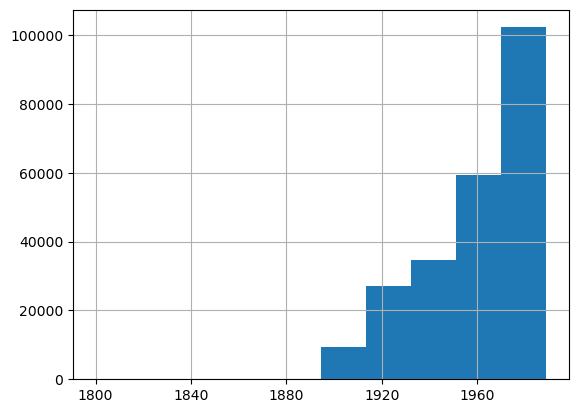

In [ ]:
pd.to_datetime(db.execute("select * from tmdb where release_date < '1989-01-01'").fetchdf().release_date).hist()

What if the nonzero revenue values occur for only more recent release dates? Let's check

<Axes: >

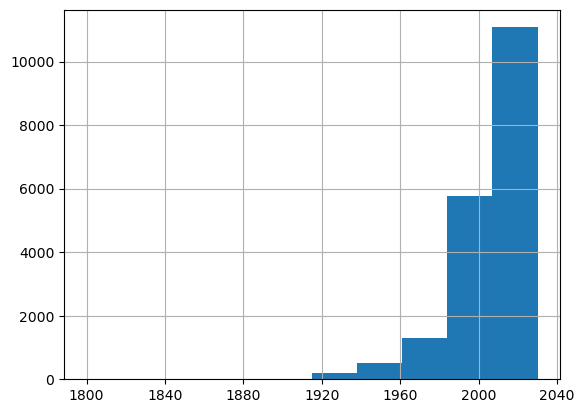

In [ ]:
pd.to_datetime(db.execute("select * from tmdb where revenue > 0").fetchdf().release_date).hist()

In [25]:
db.execute('select id, title, release_date, revenue from tmdb order by release_date asc limit 10').fetchdf()

,id,title,release_date,revenue
0,1294302,בראול סטארס בחיים האמיתיים-אלון קאט,1800-01-01,100000000.0
1,1233885,A Farsa de Inês Pereira,1800-09-11,NaN
2,1314804,Kaskisavun mailta,1837-10-29,NaN
3,1181748,Felix Nadar Spinning in his Chair,1865-01-01,NaN
4,1244969,Felix Nadar Spinning in his Chair,1865-01-01,NaN
5,1256924,Felix Nadar Spinning in his Chair,1865-01-01,NaN
6,1208472,The Frontier,1867-01-01,NaN
7,315946,Passage of Venus,1874-12-09,NaN
8,1323544,L'Amazone,1878-05-06,NaN
9,1323538,La Glissade,1878-05-06,NaN


This erratic record with id=1294302 should be deleted. When filtering for records where revenue is not null, we see one movie from 1898 and then movies from 1913 onwards. Note that the first public screening to a paying audience was in 1895. So far the data makes sense. We should set a cutoff of 1913 when doing the model training

In [26]:
db.execute("DELETE FROM tmdb WHERE id=1294302")

In [ ]:
db.execute('select id, title, release_date, revenue from tmdb where revenue is not null order by release_date asc limit 10').fetchdf()

,id,title,release_date,revenue
0,1381714,New York Stories: Life Lessons,1898-03-10,10000000
1,1301405,What is Seen Through a Keyhole,1905-07-01,1
2,1180455,"Water, Klimaat en Film",1911-02-04,1
3,96128,Traffic in Souls,1913-11-24,1800000
4,174104,The Spoilers,1914-04-10,4100000
5,572090,Neptune's Daughter,1914-04-25,5773000
6,468031,The Rose of the Rancho,1914-11-15,87028
7,402388,The Girl of the Golden West,1915-01-04,102224
8,618,The Birth of a Nation,1915-02-08,11000000
9,70368,The Cheat,1915-12-13,137365


It looks like the release_date values kind of makes sense.

In [16]:
db.execute("""
            alter table tmdb 
            alter column release_date type DATE 
            using release_date::DATE;
           """)

### Joining tmdb dataset

Now it's time to join the tmdb dataset to the movies table

In [74]:
db.execute(""" 
    create or replace temp table movies2 as
           select 
                movies1.*,
                vote_average as tmdb_ratings_avg,
                vote_count as tmdb_ratings_count,
                popularity as tmdb_popularity,
                budget,
                revenue,
                runtime as tmdb_runtime,
                release_date,
                year(release_date) as tmdb_year,
                dayofyear(release_date) as dayofyear,
                string_to_array(production_companies, ', ') as production_companies,
                upper(original_language) as original_language
           from movies1
           left join tmdb 
           on movies1.tconst = tmdb.imdb_id
""")

We should check how many of the imdb-provided Year values match with Imdb. We can do the same for runtime. The conclusion is we should coalesce

In [75]:
db.execute("select count(*) from movies2 where runtimeMinutes <> tmdb_runtime").fetchdf()

,count_star()
0,101737


In [37]:
db.execute("select count(*) from movies2 where runtimeMinutes is null and tmdb_runtime is not null").fetchdf()

,count_star()
0,41759


In [47]:
db.execute('select count(*) from movies2 where startYear <> tmdb_year').fetchdf()

,count_star()
0,28084


In [32]:
db.execute('select count(*) from movies2 where startYear is null and tmdb_year is not null').fetchdf()

,count_star()
0,1102


In [80]:
db.execute("""
           create or replace table movies as 
           select 
                tconst, 
                primaryTitle,
                isAdult,
                coalesce(startYear, tmdb_year) as year,
                coalesce(runtimeMinutes, tmdb_runtime) as runtime,
                string_to_array(genres, ',') as genres,
                imdb_ratings_avg, imdb_ratings_count, ml_ratings_avg, ml_ratings_count,
                tmdb_ratings_avg, tmdb_ratings_count, tmdb_popularity,
                budget, revenue, release_date, dayofyear, 
                week(release_date) as weeknum,
                production_companies, original_language
            from movies2;
           """)

### Preparing aggregates for names

We should redo the entire aggregation for all titles, not only movies. This is important to capture all of the works of all actors, directors and writers.

The goal is to create aggregate tables that summarize the careers of the actors, directors and writers with certain metrics

In [149]:
db.execute(""" 
            create or replace temp table titles1 as 
            select 
                imdb.*, 
                averageRating as imdb_ratings_avg,
                numVotes as imdb_ratings_count,
                movielens.ml_ratings_count,
                movielens.ml_ratings_avg
            from 
               (select * from title_basics_raw 
                where primaryTitle is not null
            ) imdb
            left join title_ratings_raw
            on imdb.tconst = title_ratings_raw.tconst
            left join 
                (select 
                    imdbId, 
                    count(rating) as ml_ratings_count, 
                    avg(rating) as ml_ratings_avg
                from ml32_ratings a 
                left join (
                    select 
                        movieId, 
                        'tt' || lpad(cast(imdbId as varchar), 7, '0') as imdbId 
                    from ml32_links
                ) as b
                on a.movieId = b.movieId 
                where imdbId is not null and rating is not null 
                group by imdbId
            ) movielens
            on imdb.tconst = movielens.imdbId;

            create or replace temp table titles2 as
            select 
                    titles1.*,
                    vote_average as tmdb_ratings_avg,
                    vote_count as tmdb_ratings_count,
                    popularity as tmdb_popularity,
                    budget,
                    revenue,
                    runtime as tmdb_runtime,
                    release_date,
                    year(release_date) as tmdb_year,
                    dayofyear(release_date) as dayofyear,
                    string_to_array(production_companies, ', ') as production_companies,
                    upper(original_language) as original_language
            from titles1 
            left join tmdb 
            on titles1.tconst = tmdb.imdb_id;

            create or replace table titles as 
            select 
                    tconst, 
                    titleType,
                    primaryTitle,
                    isAdult,
                    coalesce(startYear, tmdb_year) as year,
                    coalesce(runtimeMinutes, tmdb_runtime) as runtime,
                    string_to_array(genres, ',') as genres,
                    imdb_ratings_avg, imdb_ratings_count, ml_ratings_avg, ml_ratings_count,
                    tmdb_ratings_avg, tmdb_ratings_count, tmdb_popularity,
                    budget, revenue, release_date, 
                    week(release_date) as weeknum,
                    dayofyear, production_companies, original_language
                from titles2;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Next we should normalize the title_crew and title_principals tables as they will be joined with the titles table for aggregation

In [123]:
db.execute(""" 
    create table title_directors as (
           select tconst, unnest(string_to_array(directors, ',')) as directorid
        from title_crew_raw
    );
    create table title_writers as (
           select tconst, unnest(string_to_array(writers, ',')) as writerid
        from title_crew_raw
    );
""")

In [19]:
db.execute(""" 
    CREATE OR REPLACE TABLE directors AS       
        SELECT 
            a.nconst AS directorid, 
            a.primaryName, 
            b.ratings_avg,
            b.ratings_count,
            b.avg_revenue,
            b.total_revenue,
            b.num_titles
        FROM name_basics_raw a
        INNER JOIN (
            SELECT 
                directorid, 
                AVG(imdb_ratings_avg) AS ratings_avg,
                AVG(imdb_ratings_count) AS ratings_count,
                AVG(revenue) AS avg_revenue,
                SUM(revenue) AS total_revenue,
                COUNT(imdb_ratings_avg) AS num_titles
            FROM title_directors d
            LEFT JOIN titles c
            ON d.tconst = c.tconst
            GROUP BY directorid
        ) b
        ON a.nconst = b.directorid;
""")

In [20]:
db.execute(""" 
    CREATE OR REPLACE TABLE writers AS       
        SELECT 
            a.nconst AS writerid, 
            a.primaryName, 
            b.ratings_avg,
            b.ratings_count,
            b.avg_revenue,
            b.total_revenue,
            b.num_titles
        FROM name_basics_raw a
        INNER JOIN (
            SELECT 
                writerid, 
                AVG(imdb_ratings_avg) AS ratings_avg,
                AVG(imdb_ratings_count) AS ratings_count,
                AVG(revenue) AS avg_revenue,
                SUM(revenue) AS total_revenue,
                COUNT(imdb_ratings_avg) AS num_titles
            FROM title_writers d 
            LEFT JOIN titles c
            ON d.tconst = c.tconst
            GROUP BY writerid
        ) b
        ON a.nconst = b.writerid;
""")

From the title_principals table we extract the names that have category among ('actor, 'actress', 'self') and call these talents. These are the individuals that attract the most attention, they are the celebrities.

In [21]:
db.execute(""" 
    CREATE OR REPLACE TABLE talents AS       
        SELECT 
            a.nconst AS talentid, 
            a.primaryName, 
            b.ratings_avg,
            b.ratings_count,
            b.avg_revenue,
            b.total_revenue,
            b.num_titles
        FROM name_basics_raw a
        INNER JOIN (
            SELECT 
                nconst, 
                AVG(imdb_ratings_avg) AS ratings_avg,
                AVG(imdb_ratings_count) AS ratings_count,
                AVG(revenue) AS avg_revenue,
                SUM(revenue) AS total_revenue,
                COUNT(imdb_ratings_avg) AS num_titles
            FROM 
            (SELECT * FROM title_principals_raw WHERE category in ('actor', 'actress', 'self')) d 
            LEFT JOIN titles c
            ON d.tconst = c.tconst
            
            GROUP BY nconst
        ) b
        ON a.nconst = b.nconst;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

From this we can extract the most prolific talents across the entire imdb dataset. These names do make sense intuitively. A lot of these actors are from big superhero movies

In [22]:
db.execute('select * from talents order by total_revenue desc limit 20').fetchdf()

,talentid,primaryName,ratings_avg,ratings_count,avg_revenue,total_revenue,num_titles
0,nm0424060,Scarlett Johansson,6.760204,126379.622449,4.980717e+08,2.589973e+10,196
1,nm0000375,Robert Downey Jr.,6.744286,61737.054286,4.737093e+08,2.558030e+10,350
2,nm0262635,Chris Evans,7.011932,109645.085227,6.595298e+08,2.176448e+10,176
3,nm0749263,Mark Ruffalo,6.907254,100356.404145,4.833464e+08,1.933385e+10,193
4,nm0000168,Samuel L. Jackson,6.683450,55561.347319,2.149023e+08,1.869650e+10,429
5,nm0000332,Don Cheadle,7.081007,32064.505721,4.962142e+08,1.835993e+10,437
6,nm0719637,Jeremy Renner,7.201117,82419.871508,5.747345e+08,1.666730e+10,179
7,nm1569276,Chadwick Boseman,7.002830,86821.358491,1.005538e+09,1.508306e+10,106
8,nm0695435,Chris Pratt,7.401716,26310.752451,4.676522e+08,1.309426e+10,408
9,nm0425005,Dwayne Johnson,6.884049,16560.296524,3.256723e+08,1.302689e+10,489


Let's also make a production companies table and get their aggregate metrics

In [13]:
db.execute('select id, imdb_id, title, production_companies from tmdb limit 10').fetchdf()

,id,imdb_id,title,production_companies
0,27205,tt1375666,Inception,"Legendary Pictures, Syncopy, Warner Bros. Pict..."
1,157336,tt0816692,Interstellar,"Legendary Pictures, Syncopy, Lynda Obst Produc..."
2,155,tt0468569,The Dark Knight,"DC Comics, Legendary Pictures, Syncopy, Isobel..."
3,19995,tt0499549,Avatar,"Dune Entertainment, Lightstorm Entertainment, ..."
4,24428,tt0848228,The Avengers,Marvel Studios
5,293660,tt1431045,Deadpool,"20th Century Fox, The Donners' Company, Genre ..."
6,299536,tt4154756,Avengers: Infinity War,Marvel Studios
7,550,tt0137523,Fight Club,"Regency Enterprises, Fox 2000 Pictures, Taurus..."
8,118340,tt2015381,Guardians of the Galaxy,Marvel Studios
9,680,tt0110912,Pulp Fiction,"Miramax, A Band Apart, Jersey Films"


In [27]:
db.execute(""" 
    CREATE OR REPLACE TABLE production_companies AS
        SELECT 
            ROW_NUMBER() OVER (ORDER BY company) as companyid,
            company
        FROM (
            SELECT DISTINCT unnest(string_to_array(production_companies, ', ')) as company 
            FROM tmdb
        ) x;
""")

In [31]:
db.execute("""
    CREATE OR REPLACE TABLE title_companies AS 
        SELECT imdb_id,
            companyid,
            b.company
        FROM (
           SELECT imdb_id, unnest(string_to_array(production_companies, ', ')) as company
              FROM tmdb
           ) a
        INNER JOIN production_companies b
        ON a.company = b.company;

""")

In [32]:
db.execute(""" 
    CREATE OR REPLACE TABLE companies AS       
        SELECT 
            companyid,
            company, 
            AVG(imdb_ratings_avg) AS ratings_avg,
            AVG(imdb_ratings_count) AS ratings_count,
            AVG(revenue) AS avg_revenue,
            SUM(revenue) AS total_revenue,
            COUNT(imdb_ratings_avg) AS num_titles
        FROM title_companies a 
        LEFT JOIN titles b
        ON a.imdb_id = b.tconst
        GROUP BY companyid, company;
""")

We can now check out the production companies with the top total revenue

In [36]:
db.execute('select * from companies order by total_revenue desc limit 10').fetchdf()

,companyid,company,ratings_avg,ratings_count,avg_revenue,total_revenue,num_titles
0,153785,Warner Bros. Pictures,6.298540,40675.456706,1.090068e+08,8.033800e+10,2945
1,148838,Universal Pictures,6.252615,39669.654789,1.137184e+08,7.732853e+10,2161
2,711,20th Century Fox,6.321132,42962.721854,1.175191e+08,6.404793e+10,1661
3,106967,Paramount,6.299784,33032.857636,1.130474e+08,6.341959e+10,2318
4,31894,Columbia Pictures,6.274430,28101.042487,1.150752e+08,5.995417e+10,2589
5,153545,Walt Disney Pictures,6.414286,87335.364055,2.520171e+08,5.393167e+10,434
6,89911,Marvel Studios,7.114103,342202.602564,8.846278e+08,3.096197e+10,78
7,99212,New Line Cinema,5.990541,105685.186486,1.081267e+08,2.778856e+10,370
8,92247,Metro-Goldwyn-Mayer,6.283841,10776.789323,4.981046e+07,2.151812e+10,2791
9,41350,DreamWorks Pictures,6.676552,194340.675862,1.615745e+08,2.019681e+10,145


## Looking into 2023 movie trends

In [83]:
# Ordered by IMDb ratings count
db.execute("""select primaryTitle, imdb_ratings_avg, imdb_ratings_count, tmdb_ratings_avg, tmdb_ratings_count, revenue
           from movies where year = 2023
           order by imdb_ratings_count desc
           limit 10
           """).fetchdf()

,primaryTitle,imdb_ratings_avg,imdb_ratings_count,tmdb_ratings_avg,tmdb_ratings_count,revenue
0,Oppenheimer,8.3,819549,8.256,3766.0,9.337000e+08
1,Barbie,6.8,576950,7.279,5074.0,1.428545e+09
2,Spider-Man: Across the Spider-Verse,8.6,418555,8.442,4394.0,6.832418e+08
3,Guardians of the Galaxy Vol. 3,7.9,406921,8.023,4941.0,8.454303e+08
4,John Wick: Chapter 4,7.6,357834,7.814,4639.0,4.269786e+08
5,Poor Things,7.8,313864,NaN,NaN,NaN
6,Mission: Impossible - Dead Reckoning Part One,7.7,269731,7.740,1171.0,5.631490e+08
7,Killers of the Flower Moon,7.6,265785,NaN,NaN,NaN
8,The Super Mario Bros. Movie,7.0,253803,7.775,6743.0,1.355725e+09
9,Dungeons & Dragons: Honor Among Thieves,7.2,246307,7.459,2329.0,2.081770e+08


In [76]:
# Ordered by revenue
db.execute("""select primaryTitle, imdb_ratings_avg, imdb_ratings_count, revenue
           from movies where year = 2023
           order by revenue desc
           limit 10
           """).fetchdf()

,primaryTitle,imdb_ratings_avg,imdb_ratings_count,revenue
0,Barbie,6.8,576950,1428545028
1,The Super Mario Bros. Movie,7.0,253803,1355725263
2,Oppenheimer,8.3,819549,933700000
3,Guardians of the Galaxy Vol. 3,7.9,406921,845430302
4,Fast X,5.7,127567,704709660
5,Spider-Man: Across the Spider-Verse,8.6,418555,683241751
6,Full River Red,6.5,3480,673556758
7,The Wandering Earth II,6.7,14618,604380922
8,The Little Mermaid,7.2,161870,569244557
9,Mission: Impossible - Dead Reckoning Part One,7.7,269731,563148955


We need to combine the ratings average and ratings count. One approach would be to use a Wilson Score Confidence Interval to estimate the true rating for movies with low ratings count. However this method requires that we have all of the individual ratings values from IMDB users. Instead we can use a Bayesian average

In [87]:
ratings = db.execute('select imdb_ratings_avg as avg, imdb_ratings_count as count from movies where imdb_ratings_avg is not null').fetchdf()

In [89]:
ratings.describe()

,avg,count
count,321591.000000,3.215910e+05
mean,6.165908,3.621067e+03
std,1.383662,3.643999e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.140000e+02
max,10.000000,2.969041e+06


<Axes: >

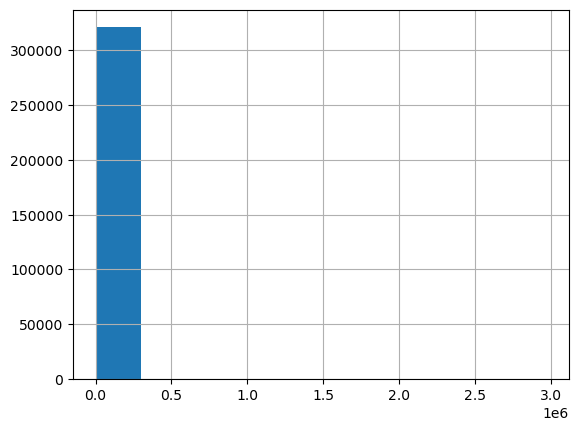

In [ ]:
ratings['count'].hist()

The ratings count is heavily right skewed. For the Bayesian average, I am making the judgement to use the 75th percentile of count, which is 314. 

In [96]:
prior  = 314
global_mean = ratings.avg.mean()
global_mean

6.16590824991993

In [97]:
db.execute(f""" 
           alter table movies add column bayesian_score float;
           update movies set 
           bayesian_score = (imdb_ratings_avg * imdb_ratings_count + {global_mean}*{prior}) / (imdb_ratings_count + {prior});
           """)

Now we can see the top 2023 movies by Bayesian average rating

In [77]:
# Ordered by revenue
db.execute("""select primaryTitle, imdb_ratings_avg, imdb_ratings_count, bayesian_score, revenue
           from movies where year = 2023
           order by bayesian_score desc
           limit 10
           """).fetchdf()

,primaryTitle,imdb_ratings_avg,imdb_ratings_count,bayesian_score,revenue
0,Janam,9.3,2034,8.880876,NaN
1,12th Fail,8.8,135023,8.793888,NaN
2,Spider-Man: Across the Spider-Verse,8.6,418555,8.598175,683241751.0
3,Kaiva,8.6,68928,8.588962,NaN
4,Suraari,9.5,771,8.535110,NaN
5,Long Drive,9.4,832,8.513870,NaN
6,Dahanam,8.8,2196,8.470476,NaN
7,20 Days in Mariupol,8.5,23766,8.469563,NaN
8,Currency Nagar,8.8,2129,8.461439,NaN
9,THEVR10: A dokumentumfilm,9.0,1235,8.425497,NaN


We can also extract a list of the most popular actors in 2023. OBserve that a lot of these actors are in the movie Barbie

In [78]:
db.execute(""" 
    SELECT * FROM 
    (
        SELECT 
            a.primaryName, 
            d.ratings_avg,
            d.ratings_count,
            d.avg_revenue,
            d.sum_revenue,
            d.num_titles
        FROM name_basics_raw a
        INNER JOIN (
            SELECT 
                nconst, 
                AVG(imdb_ratings_avg) AS ratings_avg,
                SUM(imdb_ratings_count) AS ratings_count,
                AVG(revenue) AS avg_revenue,
                SUM(revenue) as sum_revenue,
                COUNT(distinct b.tconst) AS num_titles
            FROM 
            (SELECT * FROM title_principals_raw 
            WHERE category in ('actor', 'actress')) b 
            INNER JOIN 
            (SELECT * FROM titles WHERE year = 2023 and titleType='movie') c
            ON b.tconst = c.tconst
            GROUP BY nconst
        ) d
        ON a.nconst = d.nconst
    )
    ORDER BY sum_revenue DESC 
    LIMIT 20;
""").fetchdf()

,primaryName,ratings_avg,ratings_count,avg_revenue,sum_revenue,num_titles
0,Chris Pratt,7.600000,1067645.0,1.015529e+09,3.046586e+09,2
1,Charles Martinet,7.000000,507606.0,1.355725e+09,2.711451e+09,1
2,Issa Rae,7.633333,1097433.0,1.055893e+09,2.111787e+09,3
3,Austin Freeman,7.900000,813842.0,8.454303e+08,1.690861e+09,2
4,Vin Diesel,6.800000,534488.0,7.750700e+08,1.550140e+09,2
5,Sharon Rooney,6.800000,576950.0,1.428545e+09,1.428545e+09,1
6,Ryan Gosling,6.800000,576950.0,1.428545e+09,1.428545e+09,1
7,Hari Nef,5.300000,577948.0,1.428545e+09,1.428545e+09,2
8,Alexandra Shipp,6.133333,706868.0,1.428545e+09,1.428545e+09,4
9,Margot Robbie,6.800000,576950.0,1.428545e+09,1.428545e+09,1


With some clever SQL queries, we can obtain the top 3 genres for every 5-year period to see the changes in movie trends

In [51]:
x = db.execute("""
WITH unnested AS (
  SELECT 
    FLOOR(year/5)*5 as period_start,
    FLOOR(year/5)*5 + 4 as period_end,
    unnest(genres) as genre,
    revenue
  FROM movies
),
ranked AS (
  SELECT 
    period_start,
    period_end,
    genre,
    SUM(revenue) as total_revenue,
    DENSE_RANK() OVER (
      PARTITION BY period_start 
      ORDER BY SUM(revenue) DESC
    ) as rank
  FROM unnested
  GROUP BY period_start, period_end, genre
)
SELECT 
  period_start,
  period_end,
  rank,
  genre,
  total_revenue
FROM ranked
WHERE rank <= 3
ORDER BY period_start, rank;           
""").fetchdf()

In [52]:
x.period_start = x.period_start.astype(pd.Int64Dtype())

In [56]:
x[(x.period_start >=1930) & (x.period_start<2025)].set_index(['period_start', 'rank']).drop(columns=['period_end'])

genre  total_revenue
period_start rank                          
1930         1         Drama   1.031501e+08
             2        Comedy   5.105894e+07
             3       Romance   5.096800e+07
1935         1         Drama   4.864962e+08
             2       Romance   4.827113e+08
             3           War   4.051596e+08
1940         1         Drama   4.869023e+08
             2     Animation   4.305470e+08
             3     Adventure   4.083137e+08
1945         1         Drama   6.085193e+08
             2     Film-Noir   4.318292e+08
             3         Crime   3.729336e+08
1950         1        Family   4.347257e+08
             2     Animation   4.081961e+08
             3         Drama   3.850676e+08
1955         1         Drama   7.742835e+08
             2     Adventure   5.041220e+08
             3       Romance   2.990589e+08
1960         1         Drama   9.243897e+08
             2     Adventure   8.243511e+08
             3        Comedy   6.506206e+08
1965         1         Drama   1.782981e+09
             2     Adventure   1.063067e+09
             3        Comedy   1.000464e+09
1970         1         Drama   2.771623e+09
             2        Action   1.535914e+09
             3         Crime   1.488218e+09
1975         1         Drama   3.769969e+09
             2     Adventure   3.296351e+09
             3        Comedy   2.987331e+09
1980         1        Action   5.879293e+09
             2     Adventure   5.775980e+09
             3        Comedy   5.190076e+09
1985         1        Comedy   1.182323e+10
             2         Drama   8.907207e+09
             3        Action   6.950139e+09
1990         1         Drama   1.763871e+10
             2        Comedy   1.388003e+10
             3        Action   1.225543e+10
1995         1         Drama   2.634773e+10
             2        Action   2.205988e+10
             3        Comedy   2.115345e+10
2000         1     Adventure   3.329526e+10
             2        Action   3.265199e+10
             3        Comedy   3.177976e+10
2005         1     Adventure   4.889768e+10
             2        Action   4.350505e+10
             3        Comedy   4.142647e+10
2010         1     Adventure   7.043667e+10
             2        Action   6.616349e+10
             3        Comedy   4.822618e+10
2015         1     Adventure   9.465481e+10
             2        Action   8.892123e+10
             3        Comedy   5.119330e+10
2020         1        Action   3.732927e+10
             2     Adventure   3.457789e+10
             3         Drama   2.124859e+10

That concludes our data cleaning and preparation for ML modeling. You can now proceed to the `predicting_aaa_movies.ipynb` notebook. There are still some more feature engineering that can be done

In [79]:
db.close()